In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

import pandas as pd

import random
import numpy as np
import matplotlib.pyplot as plt

## Data

In [2]:
class Dataset(Dataset):
    def __init__(self, features_file, label_file):
        features = pd.read_csv(features_file)
        labels = pd.read_csv(label_file)
        
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        tensor_features = torch.tensor(self.features.iloc[idx].values, dtype=torch.float)
        tensor_labels = torch.tensor(self.labels.iloc[idx].values, dtype=torch.float)

        return tensor_features, tensor_labels

In [3]:
dataset = Dataset('H1_AI_Dataset/H1_Features_24.csv', 'H1_AI_Dataset/H1_Labels_S_24.csv')
dataloader = DataLoader(dataset, batch_size=64, shuffle=False)

In [4]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## MLP
* 1 hidden layer
* ReLU activation
* No initialisation
* No Normalisation
* No dropout

In [6]:
class MLP(nn.Module):
    def __init__(self, input_size=25, hidden_size=128, output_size=6):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.ln1 = nn.LayerNorm(hidden_size)

        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(self.ln1(x))
        
        x = self.fc2(x)
        x = F.relu(self.ln2(x))
        
        x = self.fc3(x)  
        return x

In [7]:
class RMSE(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [8]:
# Instantiate the model, optimizer, and loss function
model = MLP()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = RMSE()

In [9]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

MLP(
  (fc1): Linear(in_features=25, out_features=128, bias=True)
  (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (fc3): Linear(in_features=128, out_features=6, bias=True)
)

## Training

In [10]:
# Training loop

train_losses = []
test_losses = []


num_epochs = 40
for epoch in range(num_epochs):

    
    model.train()  # Set the model to training mode
    total_loss = 0
    for batch_idx, (data, targets) in enumerate(train_dataloader):
        data, targets = data.to(device), targets.to(device)

        # Forward pass
        outputs = model(data)
        loss = loss_function(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()

        total_loss += loss.item()


    train_loss = total_loss/len(train_dataloader)
    train_losses.append(train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {total_loss/len(train_dataloader):.4f}')

    

    # Evaluate the model on the test set
    model.eval()  # Set the model to evaluation mode
    total_test_loss = 0
    with torch.no_grad():  # No need to track gradients for validation data
        for batch_idx, (data, targets) in enumerate(test_dataloader):
            data, targets = data.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(data)
            loss = loss_function(outputs, targets)
            
            total_test_loss += loss.item()


    test_loss = total_test_loss/len(test_dataloader)
    test_losses.append(test_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {total_test_loss/len(test_dataloader):.4f}')

Epoch [1/40], Training Loss: 47.4982
Epoch [1/40], Test Loss: 53.7742
Epoch [2/40], Training Loss: 44.5344
Epoch [2/40], Test Loss: 52.2346
Epoch [3/40], Training Loss: 43.2228
Epoch [3/40], Test Loss: 51.0489
Epoch [4/40], Training Loss: 42.2082
Epoch [4/40], Test Loss: 50.2226
Epoch [5/40], Training Loss: 41.5214
Epoch [5/40], Test Loss: 49.7588
Epoch [6/40], Training Loss: 41.0383
Epoch [6/40], Test Loss: 49.6079
Epoch [7/40], Training Loss: 40.6843
Epoch [7/40], Test Loss: 49.4711
Epoch [8/40], Training Loss: 40.4032
Epoch [8/40], Test Loss: 49.3030
Epoch [9/40], Training Loss: 40.1718
Epoch [9/40], Test Loss: 49.2438
Epoch [10/40], Training Loss: 39.9438
Epoch [10/40], Test Loss: 49.2533
Epoch [11/40], Training Loss: 39.7147
Epoch [11/40], Test Loss: 49.3850
Epoch [12/40], Training Loss: 39.5580
Epoch [12/40], Test Loss: 49.2596
Epoch [13/40], Training Loss: 39.3006
Epoch [13/40], Test Loss: 49.2617
Epoch [14/40], Training Loss: 39.1360
Epoch [14/40], Test Loss: 49.1957
Epoch [15/

## Graph of learning rate

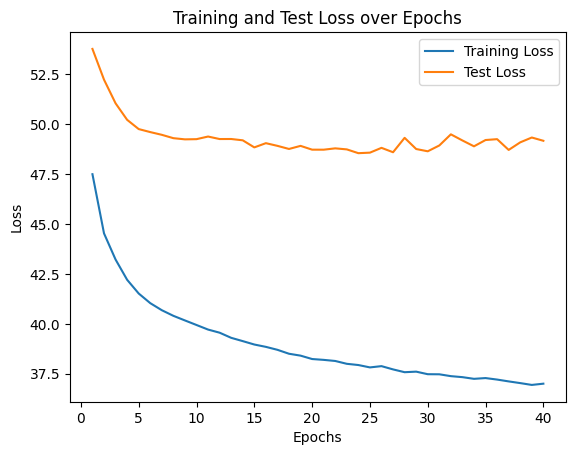

In [11]:
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.show()

# Thoughts
* Training loss is decreasing and test loss hit a plateau
* Simply a case of overfitting training data